In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch 
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import default_collate
from torcheval.metrics import MulticlassAccuracy,Mean
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from fastai.collab  import Adam
from torch.nn import init
from functools import partial
import fastcore.all as fc
from torch.optim.lr_scheduler import ExponentialLR
import math

### sen_ai is custom library built by me containing modules like Learners, Callbacks, Hooks, Progression plots, Learning Rate Finders etc
#### To install navigate to sen_ai folder and run pip install sen_ai

In [9]:
from sen_ai.conv import *
from sen_ai.core import *
from sen_ai.learner import *
from sen_ai.activations import *
from sen_ai.training import *

In [10]:
Ratings_df = pd.read_csv("cleaned_100k/ratings.csv")
Movies_df=  pd.read_csv("cleaned_100k/movies.csv")
Users_df= pd.read_csv("cleaned_100k/users.csv")

In [11]:
Ratings_df

,UserID,MovieID,Rating,Timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [12]:
Movies_df

,MovieID,Title,Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,1,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
Users_df

,UserID,MovieID,tag,Timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [14]:
class MovieDataset(Dataset):
    def __init__(self,users,movies,ratings):
        #super(MovieDataset,self).__init__()
        self.users = users
        self.rating = ratings
        self.movies = movies
        
    def __len__(self):
        return len(self.users)
    def __getitem__(self,i):
        return {'users': torch.tensor(self.users.iloc[i],dtype=torch.long),'movies': torch.tensor(self.movies.iloc[i],dtype=torch.long),'rating':torch.tensor(self.rating[i],dtype=torch.float32)}

In [15]:
movies =  LabelEncoder()
movies = movies.fit(Movies_df['MovieID'])
Ratings_df['MovieID'] =  movies.transform(Ratings_df['MovieID'])
users = LabelEncoder()
Ratings_df['UserID'] =  users.fit_transform(Ratings_df['UserID'])

In [16]:
movies.transform([85565])

array([7565], dtype=int64)

In [17]:
np.save('movies.npy', movies.classes_)
np.save('users.npy',users.classes_)

In [18]:
movies.inverse_transform([363]),users.inverse_transform([600])

(array([419], dtype=int64), array([601], dtype=int64))

In [19]:
Ratings_df

,UserID,MovieID,Rating,Timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,43,5.0,964983815
4,0,46,5.0,964982931
...,...,...,...,...
100831,609,9434,4.0,1493848402
100832,609,9461,5.0,1493850091
100833,609,9462,5.0,1494273047
100834,609,9463,5.0,1493846352


In [20]:
len(Ratings_df['MovieID'].unique())

9724

In [21]:
Ratings_df['Rating'] = Ratings_df['Rating'].map(lambda x: round(x)).values

In [22]:
Ratings_df

,UserID,MovieID,Rating,Timestamp
0,0,0,4,964982703
1,0,2,4,964981247
2,0,5,4,964982224
3,0,43,5,964983815
4,0,46,5,964982931
...,...,...,...,...
100831,609,9434,4,1493848402
100832,609,9461,5,1493850091
100833,609,9462,5,1494273047
100834,609,9463,5,1493846352


In [23]:
movie = MovieDataset(Ratings_df['UserID'],Ratings_df['MovieID'],Ratings_df['Rating'])

In [24]:
movie[:]


{'users': tensor([  0,   0,   0,  ..., 609, 609, 609]),
 'movies': tensor([   0,    2,    5,  ..., 9462, 9463, 9503]),
 'rating': tensor([4., 4., 4.,  ..., 5., 5., 3.])}

In [25]:
X_train,X_test,y_train,y_test = train_test_split(Ratings_df[['UserID','MovieID']],Ratings_df[['Rating']],test_size=0.1,random_state=42,stratify=Ratings_df['Rating'].values)
#X_valid,X_test,y_valid,y_test = train_test_split(X_test_valid,y_test_valid,test_size=0.3,random_state=101)

In [26]:
train_dataset,test_dataset = MovieDataset(X_train['UserID'],X_train['MovieID'],y_train['Rating'].to_numpy()),MovieDataset(X_test['UserID'],X_test['MovieID'],y_test['Rating'].to_numpy())

In [27]:
def collate(b): 
    b = default_collate(b)
    return torch.stack((b['users'],b['movies']),1),b['rating']
    

In [28]:
class Dataloaders:
    def __init__(self,train,test):
        self.train,self.test = train,test
    @classmethod
    def return_dl(cls,train_ds,test_ds,bs):
        return cls( DataLoader(train_ds,bs,collate_fn=collate),DataLoader(test_ds,bs,collate_fn=collate))

In [29]:
dls = Dataloaders.return_dl(train_dataset,test_dataset,bs=512)

In [30]:
next(iter(dls.train))

(tensor([[ 220, 3584],
         [ 493,  224],
         [ 559, 6282],
         ...,
         [ 248, 7999],
         [ 139, 2795],
         [ 392, 7645]]),
 tensor([4., 5., 4., 4., 2., 2., 4., 4., 4., 4., 2., 4., 4., 4., 3., 2., 2., 4.,
         3., 2., 4., 4., 5., 4., 2., 2., 4., 3., 4., 4., 4., 4., 5., 4., 4., 4.,
         4., 5., 5., 4., 4., 3., 2., 4., 4., 3., 5., 4., 4., 5., 5., 4., 3., 5.,
         3., 3., 4., 4., 4., 4., 4., 4., 3., 3., 4., 3., 5., 4., 4., 4., 4., 4.,
         3., 5., 5., 4., 1., 5., 4., 4., 4., 4., 4., 4., 2., 4., 3., 4., 4., 3.,
         1., 4., 2., 5., 2., 4., 5., 4., 4., 3., 3., 2., 3., 4., 5., 3., 4., 4.,
         4., 4., 4., 4., 2., 4., 3., 4., 0., 2., 4., 2., 4., 1., 1., 1., 4., 5.,
         1., 0., 5., 5., 3., 4., 4., 4., 5., 4., 4., 4., 4., 3., 0., 3., 4., 4.,
         3., 1., 4., 4., 5., 1., 4., 4., 4., 3., 4., 5., 4., 1., 5., 3., 4., 2.,
         3., 3., 3., 4., 5., 3., 4., 4., 4., 4., 3., 5., 4., 4., 5., 4., 4., 4.,
         4., 2., 5., 1., 5., 4., 3.,

In [25]:
#train_dl,test_dl =  DataLoader(train_dataset,64,collate_fn=collate),DataLoader(train_dataset,64,collate_fn=collate)

In [26]:
var =   next(iter(dls.train))[1]

In [27]:
var.shape

torch.Size([512])

In [28]:
#torch.stack((dic['users'],dic['movies']),1)[:,0]

# General Matrix Factorization

In [29]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [30]:
'''
class GMF(nn.Module):
    def __init__(self,n_users,n_movies,n_factors,y_range=(0,5.5)):
        super(GMF,self).__init__()
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias =  create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias =  create_params([n_movies])
        self.y_range = y_range
    def forward(self,x):
        #import pdb; pdb.set_trace()
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users * movies).sum(dim=1)
        res += self.user_bias[x[:,0]]+ self.movie_bias[x[:,1]]
        high,low =  self.y_range
        out =  (torch.sigmoid(res) * (high - low) + low)
        return out
        
    '''
    

'\nclass GMF(nn.Module):\n    def __init__(self,n_users,n_movies,n_factors,y_range=(0,5.5)):\n        super(GMF,self).__init__()\n        self.user_factors = create_params([n_users, n_factors])\n        self.user_bias =  create_params([n_users])\n        self.movie_factors = create_params([n_movies, n_factors])\n        self.movie_bias =  create_params([n_movies])\n        self.y_range = y_range\n    def forward(self,x):\n        #import pdb; pdb.set_trace()\n        users = self.user_factors[x[:,0]]\n        movies = self.movie_factors[x[:,1]]\n        res = (users * movies).sum(dim=1)\n        res += self.user_bias[x[:,0]]+ self.movie_bias[x[:,1]]\n        high,low =  self.y_range\n        out =  (torch.sigmoid(res) * (high - low) + low)\n        return out\n        \n    '

In [31]:
class GMF(nn.Module):
    def __init__(self,n_users,n_movies,n_factors,y_range=(0,5.5)):
        super(GMF,self).__init__()
        self.user_factors = nn.Embedding(n_users,n_factors)
        self.user_bias =  nn.Embedding(n_users,1)
        self.movie_factors = nn.Embedding(n_movies,n_factors)
        self.movie_bias =  nn.Embedding(n_movies,1)
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.user_bias.weight.data.uniform_(-0.01, 0.01)
        self.movie_factors.weight.data.uniform_(0, 0.05)
        self.movie_bias.weight.data.uniform_(-0.01, 0.01)
        
        self.y_range = y_range
    def forward(self,x):
        #import pdb; pdb.set_trace()
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1,keepdim=True)
        res += self.user_bias(x[:,0])+ self.movie_bias(x[:,1])
        high,low =  self.y_range
        out =  (torch.sigmoid(res) * (high - low) + low).squeeze(1)
        return out
        

In [32]:

Ratings_df['MovieID']

0            0
1            2
2            5
3           43
4           46
          ... 
100831    9434
100832    9461
100833    9462
100834    9463
100835    9503
Name: MovieID, Length: 100836, dtype: int64

In [33]:
Movies_df['Title'][0]

'Toy Story (1995)'

In [34]:
Ratings_df['UserID']

0           0
1           0
2           0
3           0
4           0
         ... 
100831    609
100832    609
100833    609
100834    609
100835    609
Name: UserID, Length: 100836, dtype: int64

In [35]:
len(Ratings_df['UserID'].unique()),len(Movies_df['MovieID'].unique())

(610, 9742)

In [36]:
nn.MSELoss()

MSELoss()

In [37]:
model  = GMF(len(Ratings_df['UserID'].unique()),len(Movies_df['MovieID'].unique()),40)
model

GMF(
  (user_factors): Embedding(610, 40)
  (user_bias): Embedding(610, 1)
  (movie_factors): Embedding(9742, 40)
  (movie_bias): Embedding(9742, 1)
)

In [40]:
device = torch.device('cuda')
n_users  = len(Ratings_df['UserID'].unique())
n_movies = len(Movies_df['MovieID'].unique())
n_factors = 40
model  = GMF(n_users,n_movies,n_factors)
mb = MetricsCB(MulticlassAccuracy())
optimizer = partial(Adam,wd=0.05)
learn = TrainLearner(model.to(device),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)

MulticlassAccuracy,loss,epoch,training
0.0,0.9880739869957078,0,True
0.0,0.8249910953072318,0,False
0.0,0.6528893937008673,1,True
0.0,0.8113146323809686,1,False
0.0,0.3840903947904853,2,True
0.0,0.8622701025255045,2,False


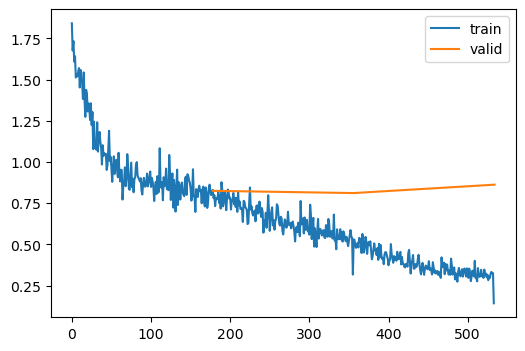

In [43]:
learn.fit(3,0.01)

MulticlassAccuracy,loss,epoch,training
0.0,0.9881344952939763,0,True
0.0,0.8247145486700777,0,False
0.0,0.6631504677666932,1,True
0.0,0.803349381068168,1,False
0.0,0.4058675984989941,2,True
0.0,0.8499697905029394,2,False


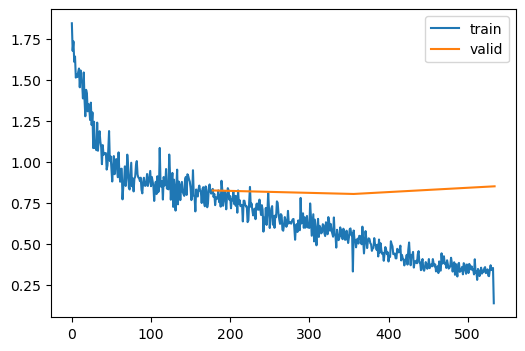

In [207]:
model  = GMF(n_users,n_movies,n_factors)
optimizer = partial(Adam,wd=0.08)
learn = TrainLearner(model.to(device),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.01)

MulticlassAccuracy,loss,epoch,training
0.0,1.0794391952381484,0,True
0.0,0.8484172283870178,0,False
0.0,0.7653932475572917,1,True
0.0,0.806857107934948,1,False
0.0,0.628582176351749,2,True
0.0,0.7882208001372456,2,False


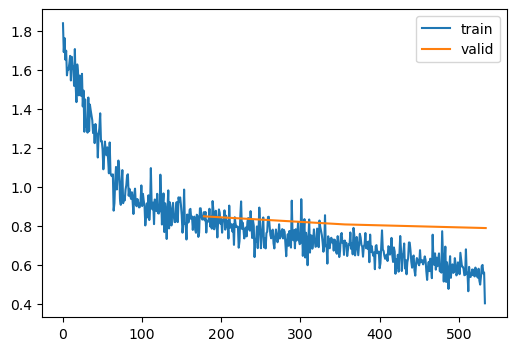

In [208]:
model  = GMF(n_users,n_movies,n_factors)
optimizer = partial(Adam,wd=0.1)
learn = TrainLearner(model.to(device),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.005)

MulticlassAccuracy,loss,epoch,training
0.0,1.0626571403740155,0,True
0.0,0.8454058963786227,0,False
0.0,0.7705525543188679,1,True
0.0,0.811038388377473,1,False
0.0,0.6493756220858592,2,True
0.0,0.7928165676384774,2,False


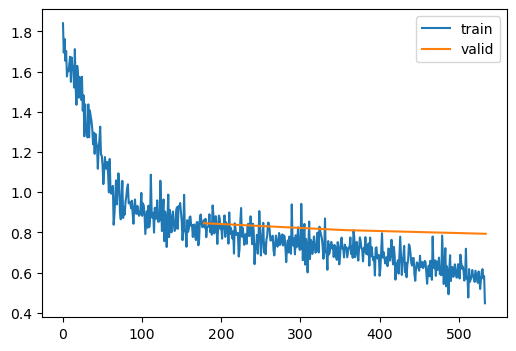

In [210]:
model  = GMF(n_users,n_movies,n_factors)
optimizer = partial(Adam,wd=0.1,mom=0.6)
learn = TrainLearner(model.to(device),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.005)

MulticlassAccuracy,loss,epoch,training
0.0,1.0644931371188466,0,True
9.91669949144125e-05,0.8475856153041018,0,False
0.0,0.7770753325460996,1,True
0.0,0.8132084956579575,1,False
0.0,0.6741331615636311,2,True
0.0,0.7941770844873763,2,False


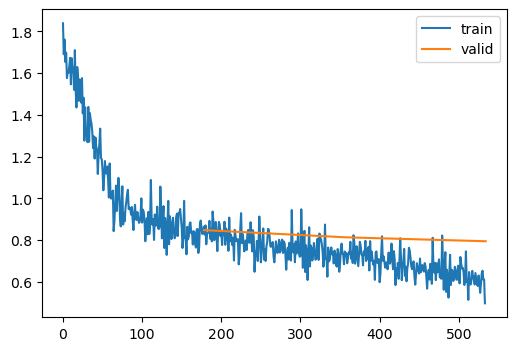

In [213]:
model  = GMF(n_users,n_movies,n_factors)
optimizer = partial(Adam,wd=0.2,mom=0.6)
learn = TrainLearner(model.to(device),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.005)

MulticlassAccuracy,loss,epoch,training
0.0,1.0671382390057251,0,True
0.0,0.850268913611019,0,False
0.0,0.7878242738660536,1,True
0.0,0.8183903707393054,1,False
0.0,0.6996063634606107,2,True
0.0,0.7940786074948945,2,False


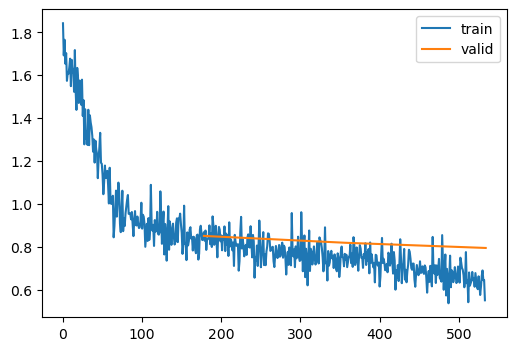

In [41]:
model  = GMF(n_users,n_movies,n_factors)
optimizer = partial(Adam,wd=0.3,mom=0.5)
learn = TrainLearner(model.to(device),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.005)

## Interpreting Embeddings

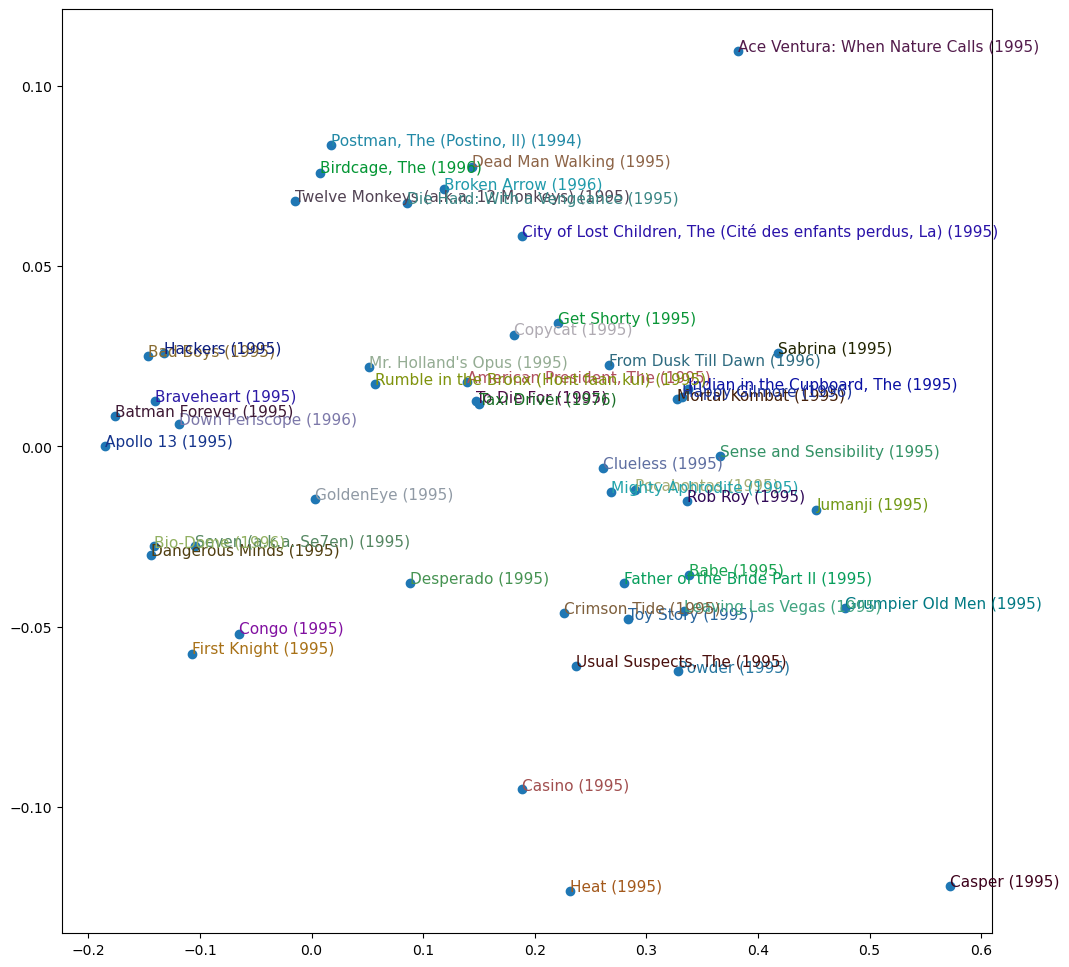

In [48]:
g = Ratings_df.groupby('MovieID')['Rating'].count()
top_idxs = g.sort_values(ascending=False).index.values[:1000]
gt = movies.inverse_transform(top_idxs)
top_movies = list(Movies_df[Movies_df['MovieID'].isin(gt)]['Title'])
movie_w = model.movie_factors.weight.data[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies, X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)

#  Neural Collaborative Filtering

In [6]:
class NCF(nn.Module):
    def __init__(self, n_users, n_movies, n_factors=100, n_hidden=30,y_range=(0,5.5),layers=None):
        super(NCF, self).__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.movie_factors = nn.Embedding(n_movies, n_factors)
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.movie_factors.weight.data.uniform_(0, 0.05)
        self.y_range  = y_range
        if layers == None:
            self.layers = nn.Sequential(nn.ReLU(),nn.Dropout(0.1),nn.Linear(n_factors*2, n_hidden),nn.ReLU(),nn.Linear(n_hidden, 1))
        else:
            self.layers  = layers
 
        
    def forward(self, x):
        U = self.user_factors(x[:,0])
        V = self.movie_factors(x[:,1])
        x = torch.cat([U, V], dim=1)
        for l in self.layers: x = l(x)
        high,low =  self.y_range
        out =  (torch.sigmoid(x) * (high - low) + low).squeeze(1)
        return out
        
       

In [32]:
def init_weights(m):
    if isinstance(m,(nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): init.kaiming_normal_(m.weight)

In [33]:
layer_infoe = torch.device('cuda')
n_users  = len(Ratings_df['UserID'].unique())
n_movies = len(Movies_df['MovieID'].unique())
n_factors = 40
model  = NCF(n_users,n_movies,n_factors)
mb = MetricsCB(MulticlassAccuracy())
optimizer = partial(Adam,wd=0.05)
learn = TrainLearner(model.to(device),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)

MulticlassAccuracy,loss,epoch,training
0.0,0.9408297504289194,0,True
0.0,0.8636171521765994,0,False
0.0,0.805221987544061,1,True
0.0,0.8632387541816708,1,False
0.0,0.765892240661492,2,True
0.0,0.880271530302684,2,False


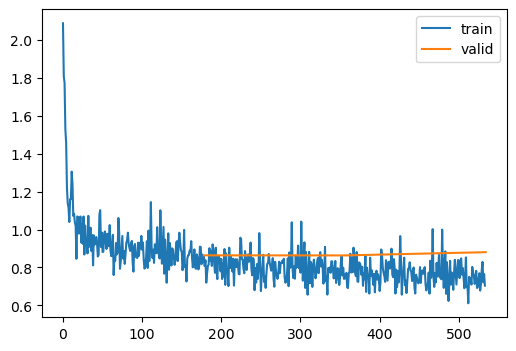

In [291]:
learn.fit(3,0.01)

MulticlassAccuracy,loss,epoch,training
0.0,0.9386184565271074,0,True
0.0,0.8377004621143334,0,False
0.0,0.7799434883806365,1,True
0.0,0.8256843563868195,1,False
0.0,0.7414913982026836,2,True
0.0,0.8266088144498324,2,False


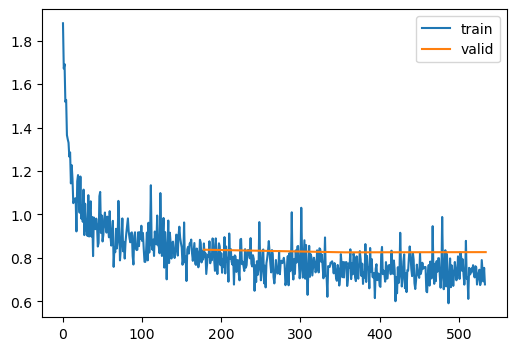

In [233]:
model  = NCF(n_users,n_movies,n_factors)
optimizer = partial(Adam,wd=0.3)
learn = TrainLearner(model.to(device),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(5,0.005)

MulticlassAccuracy,loss,epoch,training
0.0,0.8851715869392427,0,True
0.0,0.8147622108081181,0,False
0.0,0.7486032060070333,1,True
0.0,0.8061845439712664,1,False
0.0,0.7058250462723047,2,True
0.0,0.8109769900608328,2,False


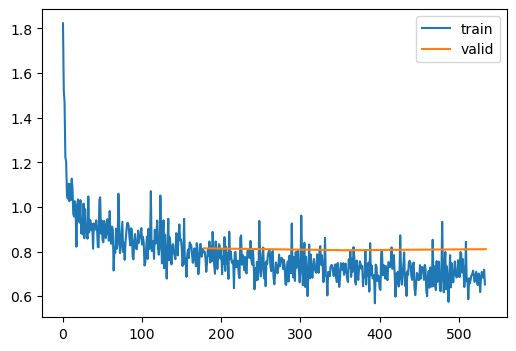

In [309]:
model  = NCF(n_users,n_movies,50)
optimizer = partial(Adam,wd=0.4,mom=0.6)
learn = TrainLearner(model.to(device).apply(init_weights),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.005)
torch.save(model, 'NCF_model/model.pth')

MulticlassAccuracy,loss,epoch,training
0.0,0.907932845258242,0,True
0.0,0.8286350375837109,0,False
0.0,0.7643970815183749,1,True
0.0,0.815369826562345,1,False
0.0,0.7242356602664727,2,True
0.0,0.8254730394084224,2,False


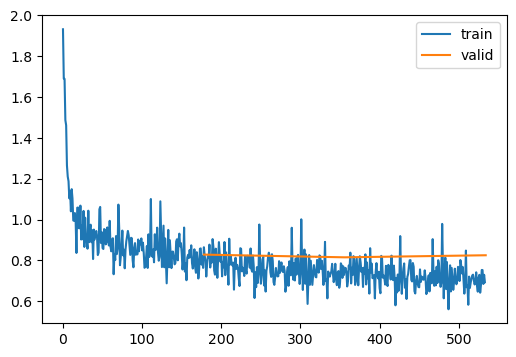

In [249]:
model  = NCF(n_users,n_movies,50)
optimizer = partial(Adam,wd=0.3,mom=0.3)
learn = TrainLearner(model.to(device).apply(init_weights),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.005)

MulticlassAccuracy,loss,epoch,training
0.0,0.8782605357331517,0,True
0.0,0.8127310244822398,0,False
1.1019041266990826e-05,0.7458133734499954,1,True
0.0,0.8071433872705601,1,False
0.0,0.6980785334059819,2,True
0.0,0.8205165083755439,2,False


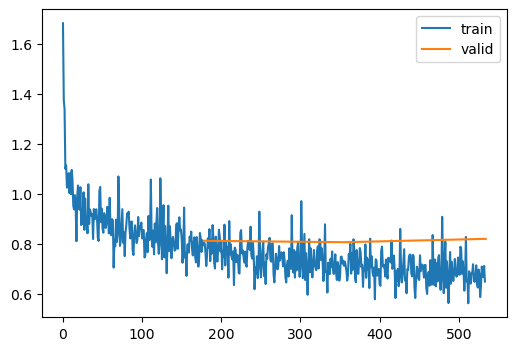

In [292]:
model  = NCF(n_users,n_movies,50)
optimizer = partial(Adam,wd=0.3,mom=0.3)
learn = TrainLearner(model.to(device).apply(init_weights),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.005)

MulticlassAccuracy,loss,epoch,training
0.0,0.8944813079490984,0,True
0.0,0.8250558619364913,0,False
0.0,0.7598395655286329,1,True
0.0,0.8188890232447829,1,False
0.0,0.7189498631170673,2,True
0.0,0.8284623033704384,2,False


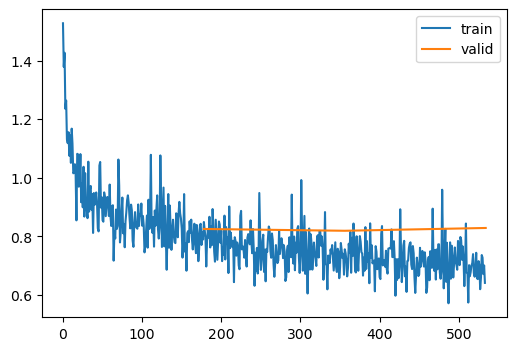

In [250]:
model  = NCF(n_users,n_movies,50)
optimizer = partial(Adam,wd=0.4,mom=0.1)
learn = TrainLearner(model.to(device).apply(init_weights),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.005)

MulticlassAccuracy,loss,epoch,training
0.0,0.8888175595966818,0,True
0.0,0.8216487940508711,0,False
0.0,0.7344522920078552,1,True
0.0,0.8102872728213862,1,False
0.0,0.6717953313725287,2,True
0.0,0.846076493223524,2,False


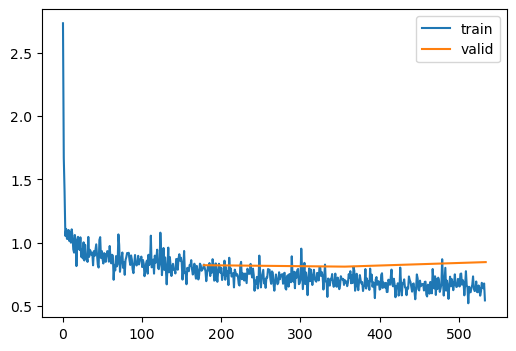

In [294]:
n_factors = 50
layers =  nn.Sequential(nn.ReLU(),nn.Linear(n_factors*2, 100),nn.ReLU(),nn.Linear(100, 50),nn.ReLU(),nn.Linear(50, 25),nn.ReLU(),nn.Linear(25, 1))
model  = NCF(n_users,n_movies,n_factors,layers=layers)
optimizer = partial(Adam,wd=0.3,mom=0.3)
learn = TrainLearner(model.to(device).apply(init_weights),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.005)

MulticlassAccuracy,loss,epoch,training
0.0,0.8796772136338507,0,True
0.0,0.8148227920138803,0,False
0.0,0.7383819185460068,1,True
0.0,0.8256363617149151,1,False
0.0,0.6843064080172433,2,True
0.0,0.8407110859599676,2,False


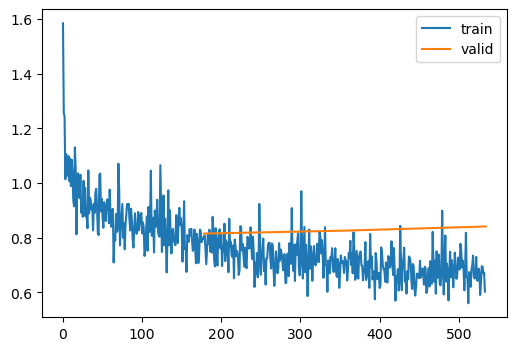

In [295]:
n_factors = 50
layers =  nn.Sequential(nn.ReLU(),nn.Dropout(0.1),nn.Linear(n_factors*2, 100),nn.ReLU(),nn.Linear(100, 50),nn.ReLU(),nn.Linear(50, 25),nn.ReLU(),nn.Linear(25, 1))
model  = NCF(n_users,n_movies,n_factors,layers=layers)
optimizer = partial(Adam,wd=0.3,mom=0.3)
learn = TrainLearner(model.to(device).apply(init_weights),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.005)

## LR Find Implpemented through Custom Callback from sen_ai


In [87]:
from torch.optim import Adam as adam
model  = NCF(n_users,n_movies,50)
optimizer = partial(adam,weight_decay=0.4,betas=(0.6,0.99))
lr = LR_find()
learn = TrainLearner(model.to(device).apply(init_weights),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),lr,mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.0005)

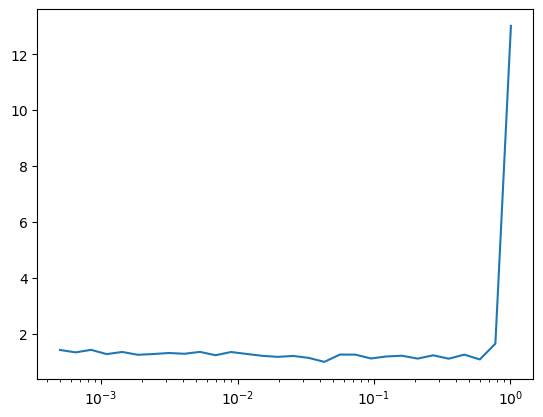

In [89]:
lr.plot()
plt.xscale('log')

MulticlassAccuracy,loss,epoch,training
0.0,0.896765390387375,0,True
0.0,0.8181665459118018,0,False
0.0,0.7526033598882355,1,True
0.0,0.8126206812240074,1,False
0.0,0.7078325420576023,2,True
0.0,0.8209207754956026,2,False


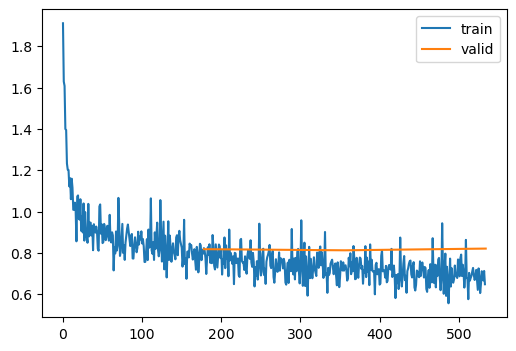

In [110]:
model  = NCF(n_users,n_movies,50)
optimizer = partial(Adam,wd=0.4,mom=0.6)
learn = TrainLearner(model.to(device).apply(init_weights),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.005)
#torch.save(model, 'NCF_model/model.pth')

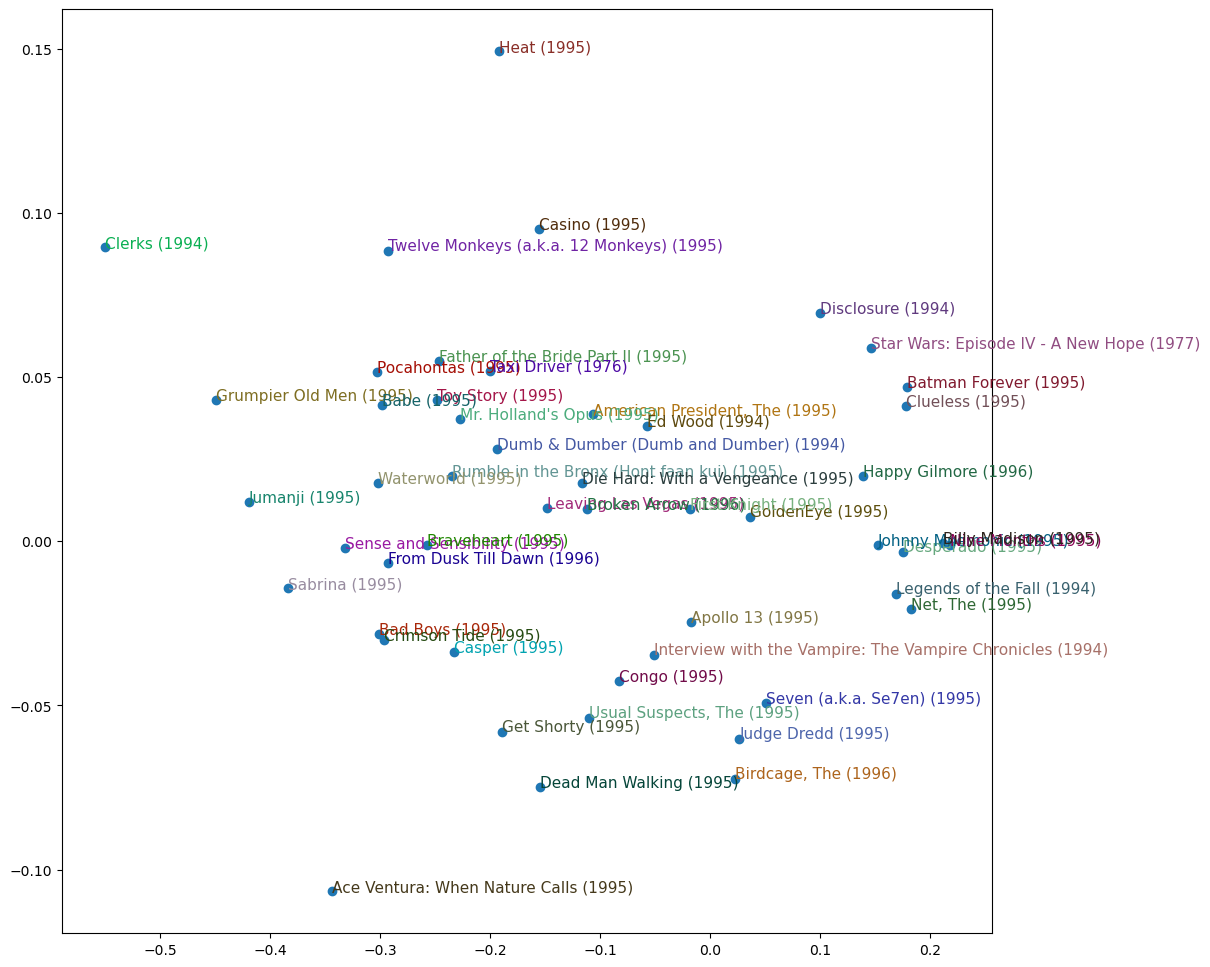

In [47]:
g = Ratings_df.groupby('MovieID')['Rating'].count()
top_idxs = g.sort_values(ascending=False).index.values[:500]
gt = movies.inverse_transform(top_idxs)
top_movies = list(Movies_df[Movies_df['MovieID'].isin(gt)]['Title'])
movie_w = model.movie_factors.weight.data[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies, X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)

## Precision@k, Recall@k and NDCG

## We Can calculate precision@k, recall@k, NDCG for a user with UserID = 479

In [234]:
from metrics import *

In [235]:
X_test

,UserID,MovieID
76294,479,376
49661,317,7562
99076,607,2014
34408,231,5923
9568,63,984
...,...,...
67565,436,934
65950,424,587
61155,398,5917
84725,546,1645


In [236]:
metrics_calc = X_test.copy()
metrics_calc['actual_rating'] = y_test.copy()

In [237]:
x_test = torch.stack((torch.tensor(list(metrics_calc['UserID'])),torch.tensor(list(metrics_calc['MovieID']))),1).to('cuda')


In [238]:
preds = model(x_test)

In [239]:
metrics_calc['pred_rating'] = preds.to('cpu').tolist()

In [240]:
metrics_calc

,UserID,MovieID,actual_rating,pred_rating
76294,479,376,2,2.347430
49661,317,7562,4,3.823892
99076,607,2014,3,3.016441
34408,231,5923,2,2.511469
9568,63,984,3,3.793173
...,...,...,...,...
67565,436,934,5,4.174861
65950,424,587,4,3.395509
61155,398,5917,2,4.359591
84725,546,1645,3,4.423774


In [242]:
user_groups = metrics_calc.groupby('UserID')
df = user_groups.get_group(479).sort_values('pred_rating',ascending = False)

In [243]:
threshold = 2.5
df['pred_rating_binary'] = df['pred_rating'] >= threshold
df['actual_rating_binary'] = df['actual_rating'] >=threshold

### Precision@k

In [244]:
precision_at_k(df,20,'actual_rating_binary','pred_rating_binary')

0.9

### Recall@k

In [245]:
recall_at_k(df,20,'actual_rating_binary','pred_rating_binary')

0.27692307692307694

### NDCG

In [246]:
ndcg_score(df['actual_rating'],df['pred_rating'])

0.6967815545392151

# Final Model

In [247]:
#X_train,X_test,y_train,y_test = train_test_split(Ratings_df[['UserID','MovieID']],Ratings_df[['Rating']],test_size=0,random_state=42,stratify=Ratings_df['Rating'].values)
train_dataset,test_dataset = MovieDataset(Ratings_df['UserID'],Ratings_df['MovieID'],Ratings_df['Rating'].to_numpy()),MovieDataset(X_test['UserID'],X_test['MovieID'],y_test['Rating'].to_numpy())
dls = Dataloaders.return_dl(train_dataset,test_dataset,bs=512)

In [248]:
model  = NCF(n_users,n_movies,50)
optimizer = partial(Adam,wd=0.4,mom=0.6)
learn = TrainLearner(model.to(device).apply(init_weights),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.005,valid=False)
torch.save(model.state_dict(), 'NCF_model/model.pth')

MulticlassAccuracy,loss,epoch,training
0.0,0.9907107687823061,0,True
0.0,0.8202882915246992,1,True
0.0,0.7757555826818074,2,True


In [4]:
torch.cuda.device_count()

1

## Pytorch Data Parallel

In [34]:
model = NCF(n_users,n_movies,50)
if torch.cuda.device_count() > 1:
    print( torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.to(device)

NCF(
  (user_factors): Embedding(610, 50)
  (movie_factors): Embedding(9742, 50)
  (layers): Sequential(
    (0): ReLU()
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=100, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [35]:
optimizer = partial(Adam,wd=0.4,mom=0.6)
learn = TrainLearner(model.to(device).apply(init_weights),dls,nn.MSELoss(),epochs = 1,lr = 0.5,cbs = [DeviceCB(),mb,ProgressCB(plot=True)],opt_func=optimizer)
learn.fit(3,0.005,valid=False)

MulticlassAccuracy,loss,epoch,training
0.0,0.8828338893243389,0,True
0.0,0.757721510693452,1,True
0.0,0.7160425814990432,2,True
